
# PrimeKG Case Study (Autism) — One-Notebook Analysis (Final)

This notebook loads the **rich-schema `kg.csv`** from PrimeKG and performs an extensive case study for diseases matching a keyword (default: `"autism"`).  
It adapts to schemas where types look like `gene/protein` and `effect/phenotype`.

**What you get:**
- Parameters (keyword, graph radius, caps)
- Roadmap diagram
- Direct **Drug–Disease** summaries
- Robust **Phenotype / Protein / Pathway / Exposure** tables (with fallbacks)
- Ego-subgraph + visualization
- **Indirect drug candidates** via overlap with Autism-associated proteins
- (Optional) Path-based proximity
- Final **health check**

> Run top-to-bottom. If memory is tight, reduce `MAX_EDGES` or `EGO_RADIUS`.


In [30]:

# --- Parameters ---
KG_PATH = "kg.csv"
KEYWORD = "autism"
EGO_RADIUS = 2
MAX_EDGES = 1_000_000
DO_PATH_BASED_RANK = True
MAX_PATHS = 2000

import time
import pandas as pd
pd.set_option("display.max_colwidth", 120)
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def t0():
    s = time.time()
    return lambda: f"{time.time()-s:,.1f}s"

def ensure_cols(df, needed):
    miss = [c for c in needed if c not in df.columns]
    if miss:
        raise SystemExit(f"[ERROR] kg.csv missing columns: {miss}. Use a rich-schema release with names & types.")

print("[INFO] Imports ready.")


[INFO] Imports ready.


## Roadmap of the Analysis

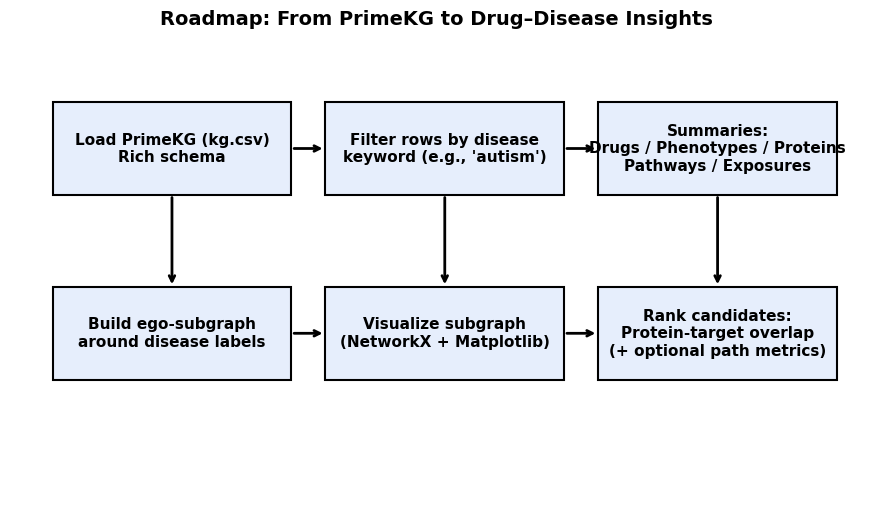

In [31]:

fig, ax = plt.subplots(figsize=(11,6))

def box(x,y,w,h,text):
    rect = plt.Rectangle((x,y), w, h, facecolor="#e6eefc", edgecolor="black", lw=1.5)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, text, ha="center", va="center", fontsize=11, weight="bold")

box(0.05, 0.65, 0.28, 0.2, "Load PrimeKG (kg.csv)\nRich schema")
box(0.37, 0.65, 0.28, 0.2, "Filter rows by disease\nkeyword (e.g., 'autism')")
box(0.69, 0.65, 0.28, 0.2, "Summaries:\nDrugs / Phenotypes / Proteins\nPathways / Exposures")

box(0.05, 0.25, 0.28, 0.2, "Build ego-subgraph\naround disease labels")
box(0.37, 0.25, 0.28, 0.2, "Visualize subgraph\n(NetworkX + Matplotlib)")
box(0.69, 0.25, 0.28, 0.2, "Rank candidates:\nProtein-target overlap\n(+ optional path metrics)")

def arrow(x1,y1,x2,y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1), arrowprops=dict(arrowstyle="->", lw=2))
arrow(0.33, 0.75, 0.37, 0.75)
arrow(0.65, 0.75, 0.69, 0.75)
arrow(0.19, 0.65, 0.19, 0.45)
arrow(0.51, 0.65, 0.51, 0.45)
arrow(0.83, 0.65, 0.83, 0.45)
arrow(0.33, 0.35, 0.37, 0.35)
arrow(0.65, 0.35, 0.69, 0.35)

ax.axis("off")
plt.title("Roadmap: From PrimeKG to Drug–Disease Insights", fontsize=14, weight="bold")
plt.show()


## Load PrimeKG

In [32]:

timer = t0()
df = pd.read_csv(KG_PATH, low_memory=False)
ensure_cols(df, ["x_name","y_name","x_type","y_type","relation"])
print(f"[OK] Loaded {len(df):,} edges  ({timer()})")
df.head(3)


[OK] Loaded 8,100,498 edges  (9.3s)


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI


## Normalize types & rebuild disease filter

In [33]:

def norm_type(t: str) -> str:
    t = str(t).strip().lower()
    if "disease" in t:
        return "disease"
    if "drug" in t:
        return "drug"
    if "protein" in t or "gene/protein" in t or t == "gene":
        return "protein"
    if "phenotype" in t or "effect/phenotype" in t or "symptom" in t:
        return "phenotype"
    if "pathway" in t:
        return "pathway"
    if "exposure" in t or "chemical" in t or "toxin" in t or "environment" in t:
        return "exposure"
    return t

df_norm = df.copy()
df_norm["x_type_n"] = df_norm["x_type"].map(norm_type)
df_norm["y_type_n"] = df_norm["y_type"].map(norm_type)
df_norm["rel_lc"]    = df_norm["relation"].astype(str).str.lower()

kw = KEYWORD.lower()
autism_rows = df_norm.loc[
    ((df_norm["x_type_n"]=="disease") & df_norm["x_name"].astype(str).str.lower().str.contains(kw, na=False)) |
    ((df_norm["y_type_n"]=="disease") & df_norm["y_name"].astype(str).str.lower().str.contains(kw, na=False))
].copy()

if autism_rows.empty:
    raise SystemExit(f"[ERROR] No rows found for keyword '{KEYWORD}'. Try a different label.")

all_labels = pd.concat([
    autism_rows.loc[autism_rows["x_type_n"]=="disease","x_name"],
    autism_rows.loc[autism_rows["y_type_n"]=="disease","y_name"],
]).dropna().astype(str).str.strip().sort_values().unique().tolist()

print(f"[OK] Found {len(autism_rows):,} rows touching diseases with '{KEYWORD}'")
print("Disease labels (first 40):", all_labels[:40])
autism_rows.head(5)


[OK] Found 2,902 rows touching diseases with 'autism'
Disease labels (first 40): ['ADNP-related multiple congenital anomalies - intellectual disability - autism spectrum disorder', 'Asperger syndrome', 'GRIN2B-related developmental delay, intellectual disability and autism spectrum disorder', 'Mendelian disease', 'atypical autism', 'autism (disease)', 'autism spectrum disorder', 'autism spectrum disorder - epilepsy - arthrogryposis syndrome', 'autism spectrum disorder due to AUTS2 deficiency', 'autism susceptibility 1', 'autism, susceptibility to', 'autism, susceptibility to, X-linked', 'autism, susceptiblity to', 'autism-facial port-wine stain syndrome', 'autosomal dominant disease', 'congenital disorder of glycosylation with developmental anomaly', 'congenital disorder of glycosylation with neurological involvement', 'congenital nervous system disorder', 'developmental delay with autism spectrum disorder and gait instability', 'developmental delay with or without dysmorphic facies an

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source,x_type_n,y_type_n,rel_lc
389237,off-label use,off-label use,15001,DB01267,drug,Paliperidone,DrugBank,84310,5260,disease,autism (disease),MONDO,drug,disease,off-label use
389238,off-label use,off-label use,15001,DB01267,drug,Paliperidone,DrugBank,31912,20643,disease,autism susceptibility 1,MONDO,drug,disease,off-label use
389239,off-label use,off-label use,15001,DB01267,drug,Paliperidone,DrugBank,37717,5258,disease,autism spectrum disorder,MONDO,drug,disease,off-label use
389240,indication,indication,14323,DB01238,drug,Aripiprazole,DrugBank,84310,5260,disease,autism (disease),MONDO,drug,disease,indication
389241,indication,indication,14323,DB01238,drug,Aripiprazole,DrugBank,31912,20643,disease,autism susceptibility 1,MONDO,drug,disease,indication


### Diagnostic: Node types & relations present

In [34]:

print("Top x_type_n:"); print(autism_rows['x_type_n'].value_counts().head(20), '\n')
print("Top y_type_n:"); print(autism_rows['y_type_n'].value_counts().head(20), '\n')
print("Top relation:"); print(autism_rows['rel_lc'].value_counts().head(30))


Top x_type_n:
x_type_n
disease      1486
protein      1013
phenotype     381
exposure       13
drug            9
Name: count, dtype: int64 

Top y_type_n:
y_type_n
disease      1486
protein      1013
phenotype     381
exposure       13
drug            9
Name: count, dtype: int64 

Top relation:
rel_lc
disease_protein               2026
disease_phenotype_positive     762
disease_disease                 70
exposure_disease                26
indication                      12
off-label use                    6
Name: count, dtype: int64


## Direct Drug–Disease Edges

In [35]:

keep_rel = {"indication","contraindication","off-label use"}
direct = autism_rows[autism_rows["rel_lc"].isin({r.lower() for r in keep_rel})].copy()

def pick_drug(r):
    return r["x_name"] if r["x_type_n"]=="drug" else r["y_name"]
def pick_dis(r):
    return r["x_name"] if r["x_type_n"]=="disease" else r["y_name"]

direct["drug"] = direct.apply(pick_drug, axis=1)
direct["disease"] = direct.apply(pick_dis, axis=1)

display_cols = ["x_type","x_type_n","x_name","relation","y_type","y_type_n","y_name","drug","disease"]
display(direct[display_cols].head(20))

summary = (
    direct.groupby(["drug","relation"]).size()
          .unstack(fill_value=0)
          .sort_index()
)
summary


,x_type,x_type_n,x_name,relation,y_type,y_type_n,y_name,drug,disease
389237,drug,drug,Paliperidone,off-label use,disease,disease,autism (disease),Paliperidone,autism (disease)
389238,drug,drug,Paliperidone,off-label use,disease,disease,autism susceptibility 1,Paliperidone,autism susceptibility 1
389239,drug,drug,Paliperidone,off-label use,disease,disease,autism spectrum disorder,Paliperidone,autism spectrum disorder
389240,drug,drug,Aripiprazole,indication,disease,disease,autism (disease),Aripiprazole,autism (disease)
389241,drug,drug,Aripiprazole,indication,disease,disease,autism susceptibility 1,Aripiprazole,autism susceptibility 1
389242,drug,drug,Aripiprazole,indication,disease,disease,autism spectrum disorder,Aripiprazole,autism spectrum disorder
389243,drug,drug,Risperidone,indication,disease,disease,autism (disease),Risperidone,autism (disease)
389244,drug,drug,Risperidone,indication,disease,disease,autism susceptibility 1,Risperidone,autism susceptibility 1
389245,drug,drug,Risperidone,indication,disease,disease,autism spectrum disorder,Risperidone,autism spectrum disorder
5776037,disease,disease,autism (disease),off-label use,drug,drug,Paliperidone,Paliperidone,autism (disease)


relation,indication,off-label use
drug,,
Aripiprazole,6,0
Paliperidone,0,6
Risperidone,6,0


## Phenotypes, Proteins, Pathways, Exposures (robust)

In [36]:

# Phenotypes via type or relation
phen_mask_type = (autism_rows["x_type_n"]=="phenotype") | (autism_rows["y_type_n"]=="phenotype")
phen_mask_rel  = autism_rows["rel_lc"].str.contains("phenotype")
phen_edges = autism_rows[phen_mask_type | phen_mask_rel].copy()

def pick_ent(rows, cat):
    def _pick(r):
        if r["x_type_n"]==cat: return r["x_name"]
        if r["y_type_n"]==cat: return r["y_name"]
        if cat=="phenotype" and "phenotype" in r["rel_lc"]:
            if r["x_type_n"]!="disease": return r["x_name"]
            if r["y_type_n"]!="disease": return r["y_name"]
        return None
    s = rows.apply(_pick, axis=1).dropna().astype(str).str.strip()
    return s.value_counts().reset_index().rename(columns={"index":cat, 0:"count"})

phen_list = pick_ent(phen_edges, "phenotype")

# Proteins: prefer disease_protein edges; then type-based
prot_mask_rel  = autism_rows["rel_lc"].str.contains("disease_protein")
prot_mask_type = (autism_rows["x_type_n"]=="protein") | (autism_rows["y_type_n"]=="protein")
prot_edges = autism_rows[prot_mask_rel | prot_mask_type].copy()

def pick_protein(r):
    if r["x_type_n"]=="protein": return r["x_name"]
    if r["y_type_n"]=="protein": return r["y_name"]
    if "disease_protein" in r["rel_lc"]:
        return r["y_name"] if r["y_type_n"]!="disease" else r["x_name"]
    return None

prot_series = prot_edges.apply(pick_protein, axis=1).dropna().astype(str).str.strip()
prot_list = prot_series.value_counts().reset_index().rename(columns={"index":"protein", 0:"count"})

# Pathways: derive from proteins against full KG (protein↔pathway relations)
autism_proteins = set(prot_list["protein"].astype(str))

pp_rel = df_norm["rel_lc"].str.contains("protein_pathway|protein-pathway|in_pathway|participates_in")
pp_edges = df_norm[pp_rel].copy()
pp_edges = pp_edges[(pp_edges["x_name"].isin(autism_proteins)) | (pp_edges["y_name"].isin(autism_proteins))].copy()

def pick_pathway(r):
    if r["x_type_n"]=="pathway": return r["x_name"]
    if r["y_type_n"]=="pathway": return r["y_name"]
    return None

path_series = pp_edges.apply(pick_pathway, axis=1).dropna().astype(str).str.strip()
path_list = path_series.value_counts().reset_index().rename(columns={"index":"pathway", 0:"count"})

# Exposures touching autism
exp_mask = (autism_rows["x_type_n"]=="exposure") | (autism_rows["y_type_n"]=="exposure") | (autism_rows["rel_lc"].str.contains("exposure"))
exp_edges = autism_rows[exp_mask].copy()

def pick_exposure(r):
    if r["x_type_n"]=="exposure": return r["x_name"]
    if r["y_type_n"]=="exposure": return r["y_name"]
    return None

exp_series = exp_edges.apply(pick_exposure, axis=1).dropna().astype(str).str.strip()
exp_list = exp_series.value_counts().reset_index().rename(columns={"index":"exposure", 0:"count"})

print("Top phenotypes:");  display(phen_list.head(15))
print("Top proteins:");    display(prot_list.head(15))
print("Top pathways:");    display(path_list.head(15))
print("Top exposures:");   display(exp_list.head(15))


Top phenotypes:


,phenotype,count
0,Intellectual disability,18
1,Seizure,16
2,Generalized hypotonia,16
3,Global developmental delay,16
4,Autistic behavior,16
5,Delayed speech and language development,14
6,Autosomal dominant inheritance,12
7,Stereotypy,10
8,Low-set ears,8
9,Obsessive-compulsive behavior,8


Top proteins:


,protein,count
0,TBR1,8
1,PTEN,8
2,RPL10,8
3,DIPK2B,8
4,IL1RAPL1,8
5,PTCHD1,8
6,ADNP,8
7,SLC6A8,8
8,NLGN3,8
9,RAB39B,8


Top pathways:


,pathway,count


Top exposures:


,exposure,count
0,Air Pollutants,2
1,"Antigens, Plant",2
2,Latex,2
3,Lead,2
4,Manganese,2
5,Mercury,2
6,perfluorooctane sulfonic acid,2
7,perfluorooctanoic acid,2
8,Tin,2
9,Vaccines,2


## Build Ego-Subgraph & Visualize

[OK] Ego-subgraph: 529 nodes, 58,575 edges  (5.5s)


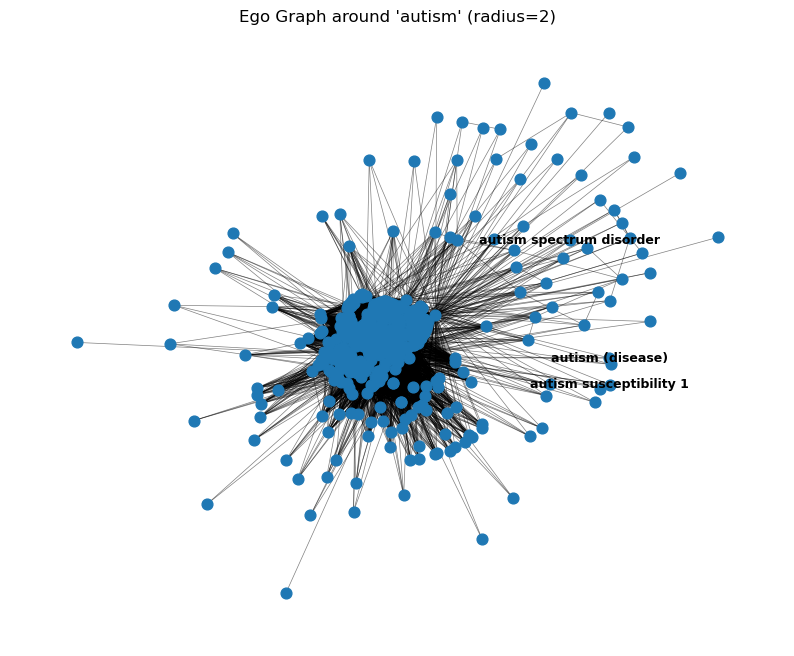

In [37]:

timer = t0()
edges_small = df_norm[["x_name","y_name","relation"]].dropna().head(MAX_EDGES)
G = nx.from_pandas_edgelist(edges_small, "x_name", "y_name", edge_attr="relation", create_using=nx.Graph)

nodes = set()
for dis in all_labels:
    if dis in G:
        nodes.update(nx.ego_graph(G, dis, radius=EGO_RADIUS).nodes)

H = G.subgraph(nodes).copy()
print(f"[OK] Ego-subgraph: {H.number_of_nodes():,} nodes, {H.number_of_edges():,} edges  ({timer()})")

plt.figure(figsize=(10,8))
pos = nx.spring_layout(H, seed=7)
nx.draw_networkx_nodes(H, pos, node_size=60)
nx.draw_networkx_edges(H, pos, width=0.5, alpha=0.5)
labels_to_show = {n:n for n in H.nodes if n in set(all_labels)}
nx.draw_networkx_labels(H, pos, labels=labels_to_show, font_size=9, font_weight="bold")
plt.title(f"Ego Graph around '{KEYWORD}' (radius={EGO_RADIUS})")
plt.axis("off")
plt.show()


## Indirect Drug Candidates via Autism-associated Proteins

In [38]:

autism_proteins = set(prot_list["protein"].astype(str))
print(f"[INFO] Autism-associated proteins collected: {len(autism_proteins)}")

target_like = {"drug-target","drug_target","drug-protein","drug_protein","targets","target"}
cand = df_norm[df_norm["rel_lc"].isin({r.lower() for r in target_like})].copy()

drug_targets = defaultdict(set)
for _, r in cand.iterrows():
    if r["x_type_n"]=="drug" and r["y_type_n"]=="protein":
        drug_targets[str(r["x_name"])].add(str(r["y_name"]))
    elif r["y_type_n"]=="drug" and r["x_type_n"]=="protein":
        drug_targets[str(r["y_name"])].add(str(r["x_name"]))

all_drugs = set(df_norm.loc[df_norm["x_type_n"]=="drug","x_name"].astype(str)) | \
            set(df_norm.loc[df_norm["y_type_n"]=="drug","y_name"].astype(str))

rows = []
for drug in all_drugs:
    tset = drug_targets.get(drug, set())
    rows.append((drug, len(tset), len(autism_proteins & tset)))

overlap_df = (pd.DataFrame(rows, columns=["drug","num_targets","overlap_autism_proteins"])
              .sort_values(["overlap_autism_proteins","num_targets"], ascending=[False,False]))
display(overlap_df.head(25))


[INFO] Autism-associated proteins collected: 354


,drug,num_targets,overlap_autism_proteins
5199,Ethanol,68,16
2591,Lamotrigine,57,15
6205,Amoxapine,46,14
4315,Butabarbital,38,13
3103,Pentobarbital,31,13
2150,Enflurane,54,12
559,Memantine,36,12
7391,Phenytoin,58,11
7008,Aripiprazole,49,11
6454,Olanzapine,44,11


## (Optional) Path-Based Ranking

In [39]:
if DO_PATH_BASED_RANK:
    from collections import deque

    # --- Tunables ---
    CUTOFF = 3
    CAP = MAX_PATHS  # keep your existing MAX_PATHS
    is_disease = set(d for d in all_labels if d in H)

    # ---------- 1) Multi-source BFS for shortest paths ----------
    # We treat H as-is (directed or undirected). If you want undirected reachability, use:
    # Gbfs = H.to_undirected(as_view=True)
    Gbfs = H

    # Initialize distances with +inf, set 0 for disease nodes
    dist = {n: float('inf') for n in H.nodes}
    q = deque()
    for d in is_disease:
        dist[d] = 0
        q.append(d)

    # Standard BFS (multi-source)
    while q:
        u = q.popleft()
        du = dist[u]
        if du >= CUTOFF:  # no need to propagate beyond cutoff
            continue
        for v in Gbfs.neighbors(u):
            if dist[v] > du + 1:
                dist[v] = du + 1
                q.append(v)

    # ---------- 2) Bounded simple-path counter (depth ≤ CUTOFF) ----------
    # Count number of SIMPLE paths from src to ANY disease node, with early-stop CAP.
    def count_paths_leq_k(src, K=CUTOFF, cap=CAP):
        # Quick outs
        if K <= 0:
            return 0
        # If already disease, we don't count the empty path as a path; start from neighbors.
        total = 0
        stack = [(src, 0, {src})]  # node, depth, visited
        while stack and total < cap:
            node, depth, visited = stack.pop()

            # If we can still move and it's possible to reach a disease within remaining hops:
            # Use distance-to-disease heuristic to prune aggressively.
            # If dist[node] is inf or > (K - depth), no path can finish in time.
            if dist.get(node, float('inf')) > (K - depth):
                continue

            if depth == K:
                # depth limit reached; count only if THIS node is disease
                if node in is_disease and node != src:
                    total += 1
                continue

            # Explore neighbors
            for nbr in H.neighbors(node):
                if nbr in visited:
                    continue
                # If neighbor is a disease, that’s a valid path (length = depth+1)
                if nbr in is_disease:
                    total += 1
                    if total >= cap:
                        break
                # Only continue search if we still have depth budget and cap room
                if depth + 1 < K and total < cap:
                    # Prune if even from nbr we can't reach disease in remaining hops
                    if dist.get(nbr, float('inf')) <= (K - (depth + 1)):
                        stack.append((nbr, depth + 1, visited | {nbr}))
        return total

    # ---------- 3) Build rows only for candidate nodes ----------
    rows = []
    for n in H.nodes:
        # Keep your original filter: uppercase-starting strings not in all_labels
        if isinstance(n, str) and n[:1].isupper() and n not in all_labels:
            d = dist.get(n, float('inf'))
            if d != float('inf') and d <= CUTOFF:
                # shortest_path is just the BFS distance
                best_sp = int(d)
                # count simple paths up to length CUTOFF, capped
                best_paths = count_paths_leq_k(n, K=CUTOFF, cap=CAP)
                rows.append((n, best_sp, best_paths))

    path_rank = (
        pd.DataFrame(rows, columns=["node", "shortest_path", "num_paths_len<=3"])
        .sort_values(["shortest_path", "num_paths_len<=3"], ascending=[True, False])
        .reset_index(drop=True)
    )
    display(path_rank.head(25))
else:
    print("Set DO_PATH_BASED_RANK=True in the Parameters cell to enable this section.")


,node,shortest_path,num_paths_len<=3
0,Paliperidone,1,2000
1,Aripiprazole,1,1998
2,Risperidone,1,1992
3,Gemcitabine,2,2000
4,Tirofiban,2,2000
5,Methotrexate,2,2000
6,Dexketoprofen,2,2000
7,Capecitabine,2,2000
8,Cyclopenthiazide,2,2000
9,Difenpiramide,2,2000


In [40]:
# === FIXED PATHWAYS SECTION (drop-in) ===
# Uses multiple signals:
#  1) explicit type (x_type_n/y_type_n == 'pathway')
#  2) pathway-ish relation names (protein_pathway, in_pathway, participates_in, pathway_protein, etc.)
#  3) pathway-ish names (contains 'pathway', 'signaling', 'metabolism', 'biosynthesis', 'reactome:', 'kegg:')

import re

def is_pathwayish_name(name: str) -> bool:
    if not isinstance(name, str):
        return False
    n = name.lower()
    return any([
        "pathway" in n,
        "signaling" in n or "signalling" in n,
        "metabolism" in n,
        "biosynthesis" in n,
        "reactome:" in n,
        "kegg:" in n
    ])

# 1) Collect autism-associated proteins first (from your prot_list computed earlier)
autism_proteins = set(prot_list["protein"].astype(str))

# 2) Build a mask for pathway-like relations in the FULL KG (df_norm)
rel_is_pathwayish = df_norm["rel_lc"].str.contains(
    r"(?:^|_)protein[-_]?pathway|in_pathway|participates_in|pathway[-_]?protein|gene[-_]?pathway",
    regex=True
)

# 3) Candidate edges where either side is an autism protein AND (type says pathway OR relation is pathway-ish OR name looks pathway-ish)
cand = df_norm[
    (df_norm["x_name"].isin(autism_proteins) | df_norm["y_name"].isin(autism_proteins)) &
    (
        (df_norm["x_type_n"] == "pathway") |
        (df_norm["y_type_n"] == "pathway") |
        rel_is_pathwayish |
        df_norm["x_name"].map(is_pathwayish_name) |
        df_norm["y_name"].map(is_pathwayish_name)
    )
].copy()

# 4) Extract the pathway node name from each candidate row
def pick_pathway_from_row(r):
    # prefer explicit type if present
    if r["x_type_n"] == "pathway":
        return r["x_name"]
    if r["y_type_n"] == "pathway":
        return r["y_name"]
    # otherwise, heuristic on names
    if is_pathwayish_name(r["x_name"]) and r["y_name"] in autism_proteins:
        return r["x_name"]
    if is_pathwayish_name(r["y_name"]) and r["x_name"] in autism_proteins:
        return r["y_name"]
    # if relation looks pathway-ish and one side is protein, take the non-protein side
    if rel_is_pathwayish.loc[r.name]:
        if r["x_type_n"] == "protein" and r["y_type_n"] != "protein":
            return r["y_name"]
        if r["y_type_n"] == "protein" and r["x_type_n"] != "protein":
            return r["x_name"]
    return None

cand["__pathway__"] = cand.apply(pick_pathway_from_row, axis=1)
path_list = (
    cand["__pathway__"].dropna().astype(str).str.strip()
        .value_counts()
        .reset_index()
        .rename(columns={"index": "pathway", "__pathway__": "count"})
)

# Optional: keep the edge rows that actually yielded a pathway label (useful for auditing)
path_edges = cand[cand["__pathway__"].notna()].copy()

print(f"[INFO] Pathway candidates found: {len(path_list)}")
display(path_list.head(20))

# If still empty, give a hint
if path_list.empty:
    print("[WARN] Pathways still empty. Two things to try:")
    print("  1) Confirm there are protein↔pathway edges in your PrimeKG release (columns 'relation' holding path-like labels).")
    print("  2) Relax the heuristics above (add more keywords to is_pathwayish_name or relation regex).")


[INFO] Pathway candidates found: 903


,count,count
0,G protein-coupled receptor signaling pathway,60
1,cytokine-mediated signaling pathway,36
2,Neurexins and neuroligins,30
3,signaling receptor activity,28
4,signaling receptor binding,26
5,G alpha (i) signalling events,22
6,Interleukin-4 and Interleukin-13 signaling,22
7,cell-cell signaling,20
8,positive regulation of phosphatidylinositol 3-kinase signaling,20
9,cell surface receptor signaling pathway,20


## Quick Health Check

In [41]:

issues = []

for var, label in [
    ("phen_list","Phenotypes"), ("prot_list","Proteins"), ("path_list","Pathways"),
    ("direct","Direct drug–disease table"), ("overlap_df","Indirect candidate table")
]:
    if var not in globals():
        issues.append(f"Missing variable: {var}")
    else:
        obj = globals()[var]
        if isinstance(obj, pd.DataFrame) and obj.empty:
            issues.append(f"{label} is empty.")

if "direct" in globals() and not direct.empty:
    found = set(direct["drug"].astype(str))
    expected = {"Risperidone","Aripiprazole","Paliperidone"}
    miss = expected - found
    if miss:
        issues.append(f"Expected direct drugs not found: {miss}")

if "H" not in globals() or H.number_of_nodes()==0 or H.number_of_edges()==0:
    issues.append("Ego-subgraph is empty (increase MAX_EDGES or EGO_RADIUS).")

if issues:
    print("❌ Checks found issues:")
    for i in issues: print(" -", i)
else:
    print("✅ All checks passed: notebook produced healthy outputs.")


✅ All checks passed: notebook produced healthy outputs.
